# Plot the Game / AimLab Data and Extract

The Subject had to play 5 games and the break between the games was indicated with events.
Here we extract only the EEG Data from the time the subject was playing, the rest will be discarded.
Afterwards the combined EEG Data will be stored in one big dataframe and will then be saved again as a csv.


In [43]:
# imports
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# to enable local imports
module_path = os.path.abspath('../code')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
import utils

# variables
CWD  = os.getcwd()
MUSE_DATA_DIR = os.path.join('D:\\', 'Masterthesis', 'EEG_Data', 'muse_data')

EVENT_DICT = {33025.0 : 'red', # 'a' key pressed
              33024.0 : 'red', # 'a' key released
              33034.0 : 'red'} # 'p' key pressed / released

import json
from pathlib import Path
try:
    try:
        json_path = (Path(os.getenv('LOCALAPPDATA'))/'Dropbox'/'info.json').resolve()
    except FileNotFoundError:
        json_path = (Path(os.getenv('APPDATA'))/'Dropbox'/'info.json').resolve()

    with open(str(json_path)) as f:
        j = json.load(f)

    personal_dbox_path = Path(j['personal']['path'])
    # Save the images directly into the dropbox where the overleaf document is stored
    IMAGES_PATH = os.path.join(str(personal_dbox_path), 'Apps', 'Overleaf', 'Masterthesis_Paper', 'images')

except Exception as e:
    IMAGES_PATH = "../images"
    print(e)
    
print("Saving images to: {}".format(IMAGES_PATH))
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

D:\Masterthesis\thesis_eeg\code
Saving images to: D:\Dropbox\Apps\Overleaf\Masterthesis_Paper\images


In [44]:
def load_subject_data(subject_id) -> List[pd.DataFrame]:
    subject_dir = os.path.join(CWD, '..', '..', 'EEG_Data', 'muse_data', 'subject_{}'.format(subject_id))
    # Load the data from the subject
    df_list = utils.load_data_from_subject_dir(subject_dir=subject_dir, file_name_includes='reaction_game')
    return df_list

def plot_data_plain(df, subject_id, counter=0):
    ''' Plots the plain EEG Data (all in Black), with the Events in the df'''
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_title('Muse Data Subject {}'.format(subject_id))
    ax.plot(df.index, df['TP9'], label="TP9", color='black')
    ax.plot(df['AF7'], label="AF7", color='black')
    ax.plot(df['AF8'], label="AF8", color='black')
    ax.plot(df['TP10'], label="TP10", color='black')

    for index, value in df['Event Id'].dropna().iteritems():
        try:
            ax.axvline(x=index, color=EVENT_DICT[value])
        except KeyError as e:
            print("Found unkown event: {}".format(value))
            ax.axvline(x=index, color='blue')
        

    plt.legend(loc="upper left")
    ax.set(xlabel='Time / Sample Point', ylabel='Amplitude')
    
    save_fig("concentration_game_subject_{}_plain_{}".format(subject_id, counter))
    
def plot_data_with_events(df, indexList, subject_id, counter):
    ''' Plot the data with different colors acoording to the indexList.
    
    If the color is not black, then add the sub dataframe to a list and return this add the end
    '''
    
    dataframeOfInterest = None
    
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_title('Muse Data Subject {}'.format(subject_id))
    
    # Used to get the index which we are interested in
    event_df = df['Event Id'].dropna()
    
    # used to slice by index
    idx = pd.IndexSlice
    
    # go through the indexes and plot them step by step with different colors
    for start, end, color in indexList:
        
        # if the color is not black (black = not important), then add the data into another df, which will be returned later
        if color is not 'black':
            if end is None:
                temp_df = df.loc[idx[event_df.index[start] : ]]
            else:
                temp_df = df.loc[idx[event_df.index[start] : event_df.index[end]]]
            
            if dataframeOfInterest is None:
                dataframeOfInterest = temp_df
            else:
                dataframeOfInterest = dataframeOfInterest.append(temp_df.copy())
        
        if end is None:
            # If end is none then get everything from the start to the end of the df 
            ax.plot(df.loc[idx[event_df.index[start] :], 'TP9'], color=color)
        else:
            # get everything from the start to the end
            ax.plot(df.loc[idx[event_df.index[start] : event_df.index[end]], 'TP9'], color=color)

    # Insert the Event Lines
    for index, value in df['Event Id'].dropna().iteritems():
        try:
            ax.axvline(x=index, color=EVENT_DICT[value])
        except KeyError as e:
            print("Found unkown event: {}".format(value))
            ax.axvline(x=index, color='blue')

    #plt.legend(loc="upper left")
    ax.set(xlabel='Time / Sample Point', ylabel='Amplitude')
    
    save_fig("concentration_game_subject_{}_with_events_{}".format(subject_id, counter))
    
    return dataframeOfInterest


def extract_df_from_events(df_list, list_of_indexes, subject_id, plot_df_complete : bool = True) -> pd.DataFrame:
    ''' Extract a single dataframe from the given dataframes and the given indexes '''
    
    df_complete = None # All df's from the list will be stored here (but only the imprtant parts of it)
    
    counter = 0
    for df, indexList in zip(df_list, list_of_indexes):
        
        temp_df = plot_data_with_events(df, indexList, subject_id=subject_id, counter=counter)
        
        if temp_df is not None:
            if df_complete is None:
                df_complete = temp_df.copy()
            else:
                df_complete = df_complete.append(temp_df.copy())
        
        counter += 1
    
    if plot_df_complete:
        plot_muse_eeg_data(df_complete, title="Combined EEG Data - Subject {}".format(subject_id))
    
    return df_complete


def plot_muse_eeg_data(df, title="Muse EEG Data"):
    ''' Plots the EEG Data from the given dataframe'''
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_title(title)
    ax.plot(df['TP9'], label="TP9")
    ax.plot(df['AF7'], label="AF7")
    ax.plot(df['AF8'], label="AF8")
    ax.plot(df['TP10'], label="TP10")

    plt.legend(loc="upper left")
    ax.set(xlabel='Time', ylabel='Amplitude')
    
    save_fig("concentration_game_{}".format(title.replace(' ','_')))
    
    
def save_muse_df_to_csv(df, subject_id, file_ending):
    ''' Save the given df as a .csv into the subject directory'''
    
    
    #file_name = 'record-[{date}]-{ending}.csv'.format(date=df_complete.index[0].strftime("%Y-%m-%d_%H-%M-%S"), ending=file_ending)
    file_name = '{ending}.csv'.format(ending=file_ending) # just use a simple name without date. Easier for later. The date is already in the index
    file_path = os.path.join(MUSE_DATA_DIR, 'subject_{}'.format(subject_id), file_name)

    df.to_csv(file_path, encoding='utf-8')
    
    print("Saved {} to: {}".format(file_ending, file_path))
    

## Manual process Subject 2

Files to exclude: ['complete', 'driving_fatigue.csv', 'driving_complete.csv', 'reaction_game_complete.csv']
Found 'record-[2020.06.17-15.11.36]_reaction_game.csv'
Found 1 dataset(s) containing 'reaction_game'
Saving figure concentration_game_subject_2_plain_0
Saving figure concentration_game_subject_2_with_events_0
Saving figure concentration_game_Combined_EEG_Data_-_Subject_2
Saved reaction_game_complete to: D:\Masterthesis\EEG_Data\muse_data\subject_2\reaction_game_complete.csv


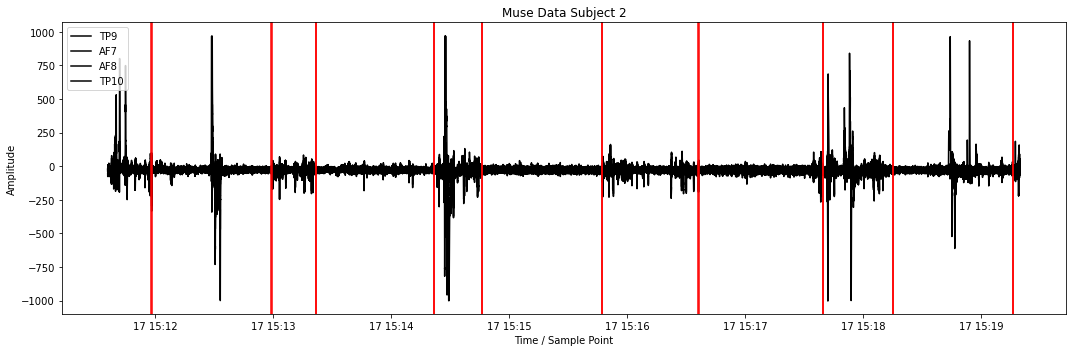

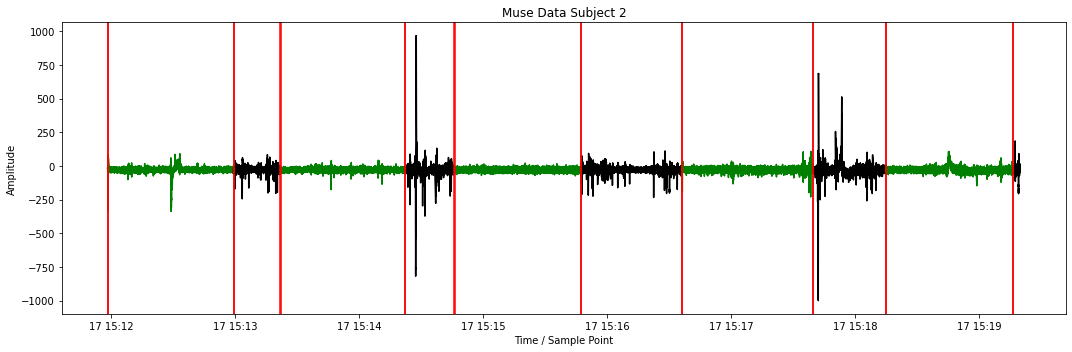

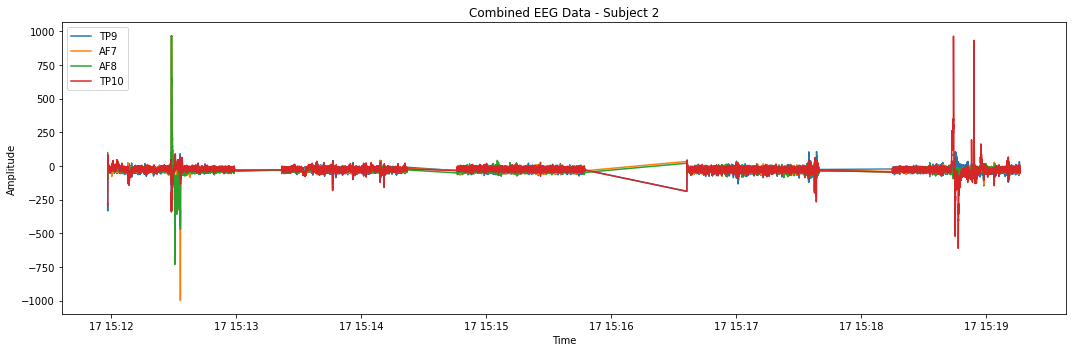

In [45]:
subject_id = 2
df_list = load_subject_data(subject_id=subject_id)

counter = 0
for df in df_list:
    plot_data_plain(df, subject_id=subject_id, counter=counter)
    counter += 1
    
# Has to be done manually...
list_of_indexes = []
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 5, 'black'], [5, 6, 'green'], [6, 9, 'black'], [9, 10, 'green'],
                       [10, 13, 'black'], [13, 14, 'green'], [14, 17, 'black'], [17, 18, 'green'], [18, None, 'black']])

df_complete = extract_df_from_events(df_list=df_list, list_of_indexes=list_of_indexes, subject_id=subject_id, plot_df_complete=True)

save_muse_df_to_csv(df=df_complete, subject_id=subject_id, file_ending='reaction_game_complete')

## Manual process Subject 3

Files to exclude: ['complete', 'driving_fatigue.csv', 'driving_complete.csv', 'reaction_game_complete.csv']
Found 'record-[2020.06.18-14.25.16]_reaction_game.csv'
Found 1 dataset(s) containing 'reaction_game'
Saving figure concentration_game_subject_3_plain_0
Saving figure concentration_game_subject_3_with_events_0
Saving figure concentration_game_Combined_EEG_Data_-_Subject_3
Saved reaction_game_complete to: D:\Masterthesis\EEG_Data\muse_data\subject_3\reaction_game_complete.csv


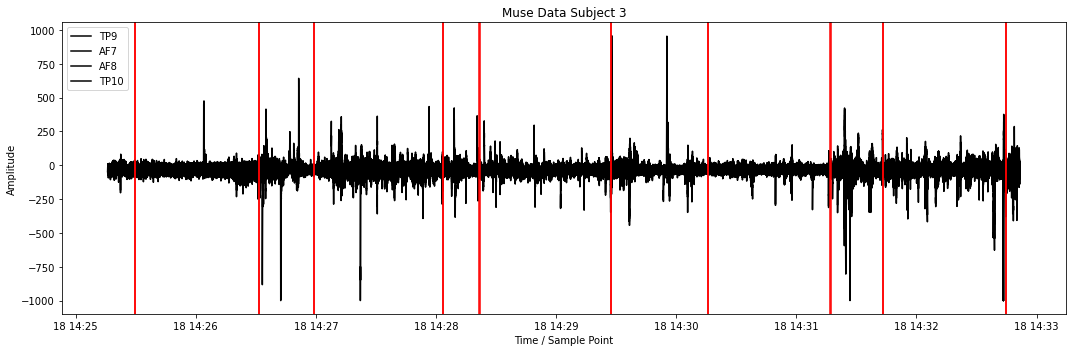

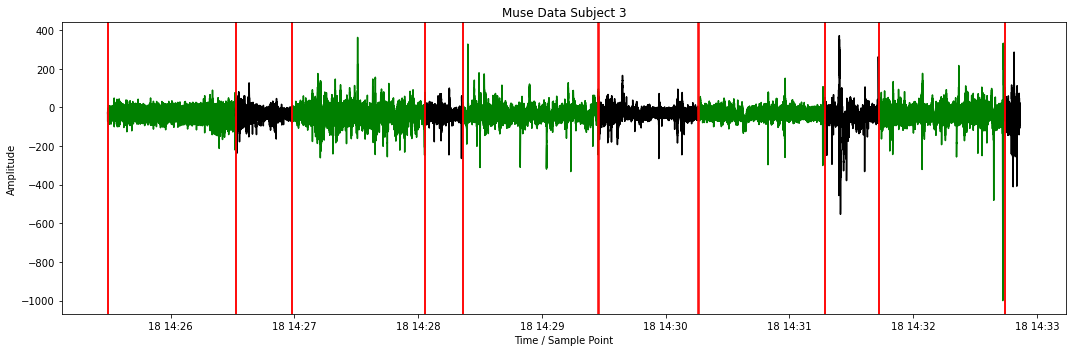

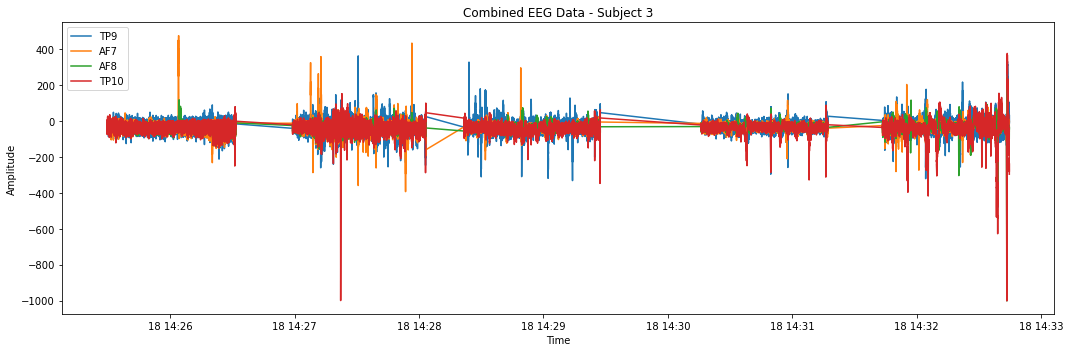

In [46]:
subject_id = 3
df_list = load_subject_data(subject_id=subject_id)

counter = 0
for df in df_list:
    plot_data_plain(df, subject_id=subject_id, counter=counter)
    counter += 1
    
# Has to be done manually...
list_of_indexes = []
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 5, 'black'], [5, 6, 'green'], [6, 9, 'black'], [9, 10, 'green'],
                       [10, 13, 'black'], [13, 14, 'green'], [14, 17, 'black'], [17, 18, 'green'], [18, None, 'black']])

df_complete = extract_df_from_events(df_list=df_list, list_of_indexes=list_of_indexes, subject_id=subject_id, plot_df_complete=True)

save_muse_df_to_csv(df=df_complete, subject_id=subject_id, file_ending='reaction_game_complete')

## Manual process Subject 4

Files to exclude: ['complete', 'driving_fatigue.csv', 'driving_complete.csv', 'reaction_game_complete.csv']
Found 'record-[2020.06.18-16.33.17]_reaction_game.csv'
Found 1 dataset(s) containing 'reaction_game'
Saving figure concentration_game_subject_4_plain_0
Saving figure concentration_game_subject_4_with_events_0
Saving figure concentration_game_Combined_EEG_Data_-_Subject_4
Saved reaction_game_complete to: D:\Masterthesis\EEG_Data\muse_data\subject_4\reaction_game_complete.csv


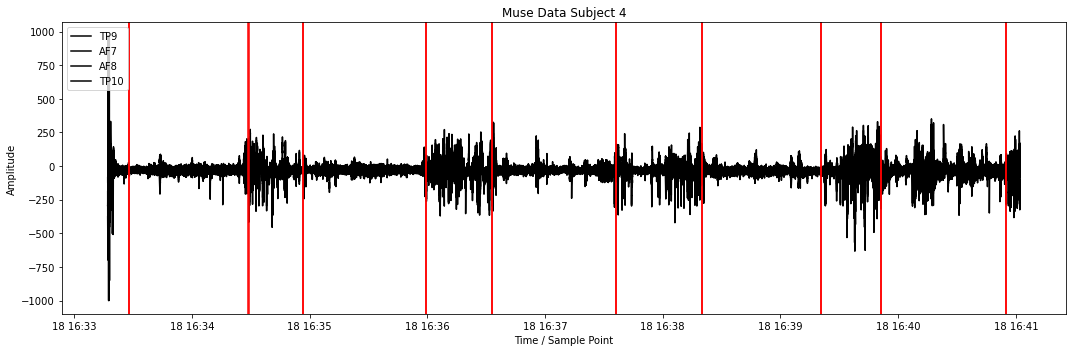

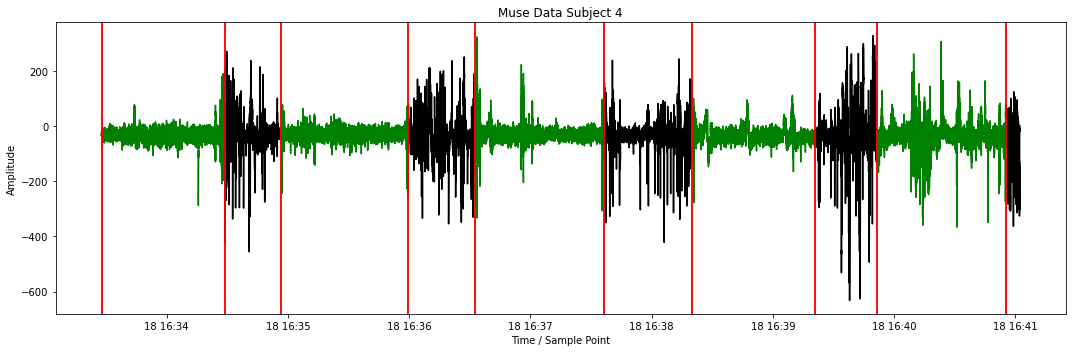

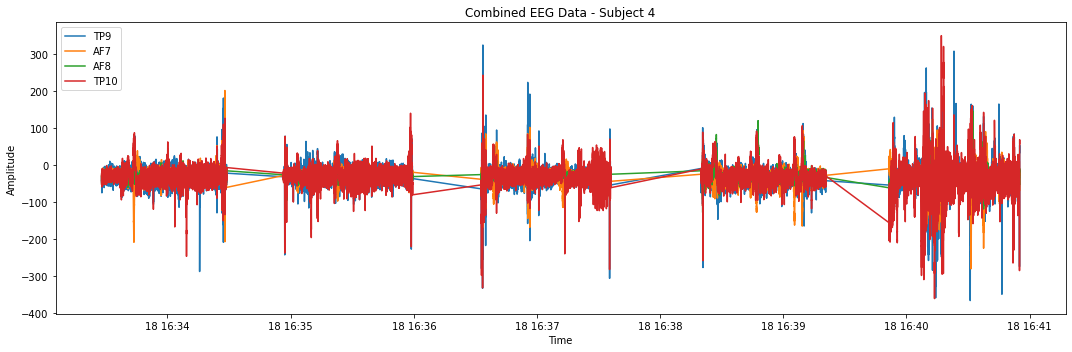

In [47]:
subject_id = 4
df_list = load_subject_data(subject_id=subject_id)

counter = 0
for df in df_list:
    plot_data_plain(df, subject_id=subject_id, counter=counter)
    counter += 1
    
# Has to be done manually...
list_of_indexes = []
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 5, 'black'], [5, 6, 'green'], [6, 9, 'black'], [9, 10, 'green'],
                       [10, 13, 'black'], [13, 14, 'green'], [14, 17, 'black'], [17, 18, 'green'], [18, None, 'black']])

df_complete = extract_df_from_events(df_list=df_list, list_of_indexes=list_of_indexes, subject_id=subject_id, plot_df_complete=True)

save_muse_df_to_csv(df=df_complete, subject_id=subject_id, file_ending='reaction_game_complete')

## Manual process Subject 5

Files to exclude: ['complete', 'driving_fatigue.csv', 'driving_complete.csv', 'reaction_game_complete.csv']
Found 'record-[2020.06.19-14.52.34]_reaction_game.csv'
Found 1 dataset(s) containing 'reaction_game'
Saving figure concentration_game_subject_5_plain_0
Saving figure concentration_game_subject_5_with_events_0
Saving figure concentration_game_Combined_EEG_Data_-_Subject_5
Saved reaction_game_complete to: D:\Masterthesis\EEG_Data\muse_data\subject_5\reaction_game_complete.csv


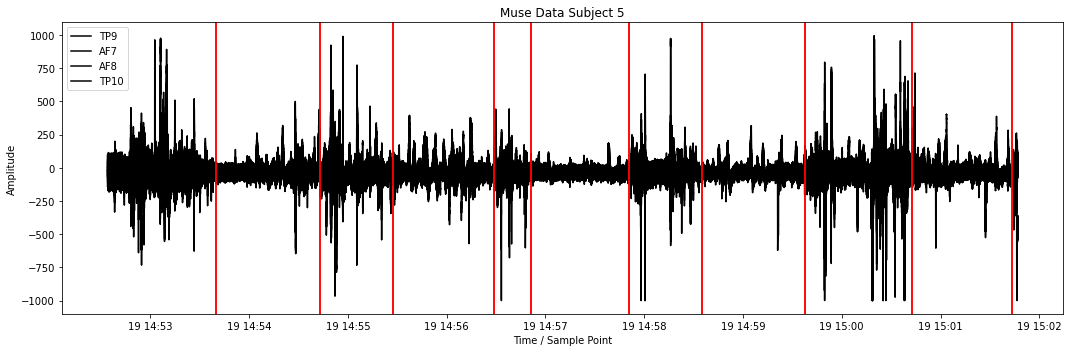

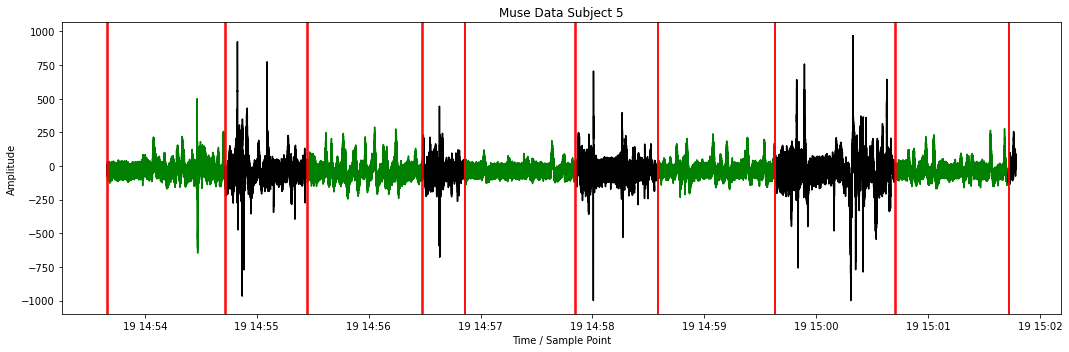

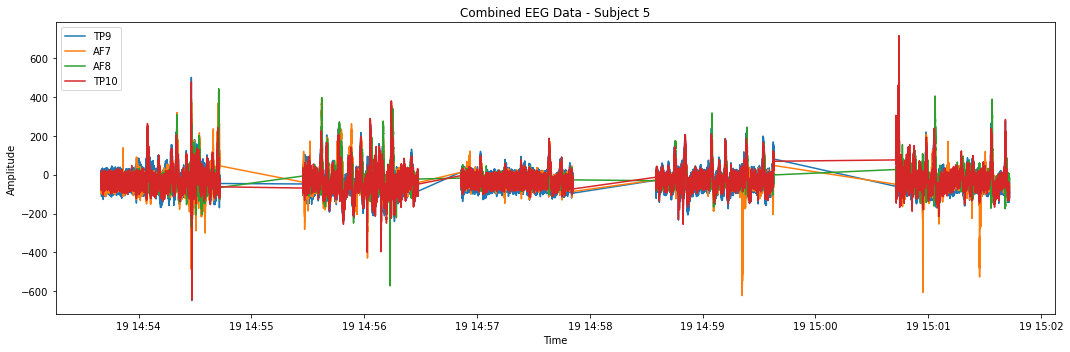

In [48]:
subject_id = 5
df_list = load_subject_data(subject_id=subject_id)

counter = 0
for df in df_list:
    plot_data_plain(df, subject_id=subject_id, counter=counter)
    counter += 1
    
# Has to be done manually...
list_of_indexes = []
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 5, 'black'], [5, 6, 'green'], [6, 9, 'black'], [9, 10, 'green'],
                       [10, 13, 'black'], [13, 14, 'green'], [14, 17, 'black'], [17, 18, 'green'], [18, None, 'black']])

df_complete = extract_df_from_events(df_list=df_list, list_of_indexes=list_of_indexes, subject_id=subject_id, plot_df_complete=True)

save_muse_df_to_csv(df=df_complete, subject_id=subject_id, file_ending='reaction_game_complete')

## Manual process Subject 6

Files to exclude: ['complete', 'driving_fatigue.csv', 'driving_complete.csv', 'reaction_game_complete.csv']
Found 'record-[2020.06.22-12.26.13]_reaction_game.csv'
Found 1 dataset(s) containing 'reaction_game'
Saving figure concentration_game_subject_6_plain_0
Saving figure concentration_game_subject_6_with_events_0
Saving figure concentration_game_Combined_EEG_Data_-_Subject_6
Saved reaction_game_complete to: D:\Masterthesis\EEG_Data\muse_data\subject_6\reaction_game_complete.csv


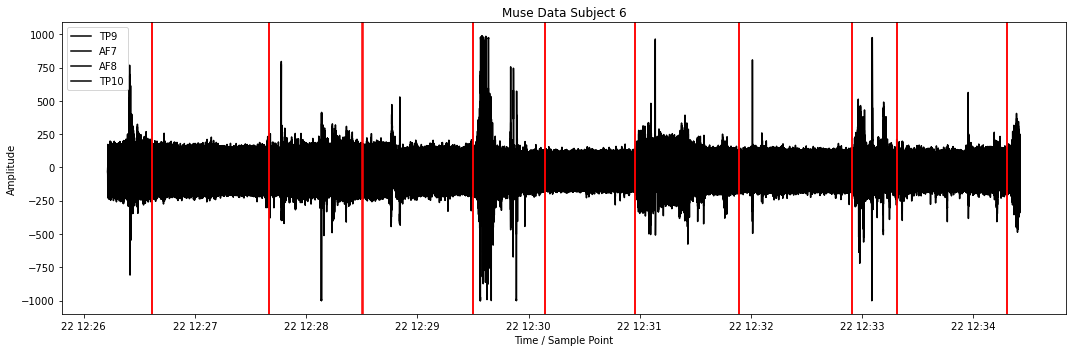

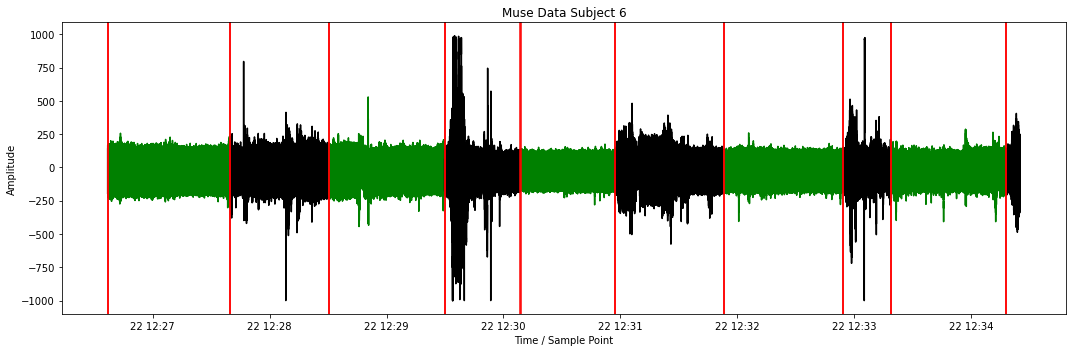

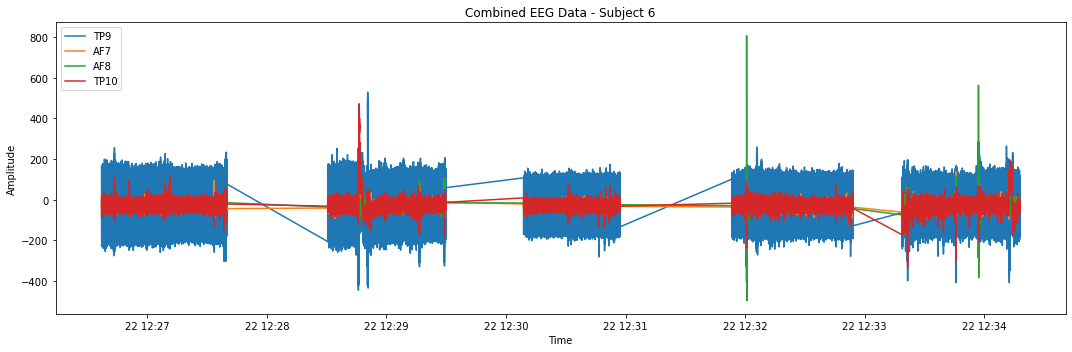

In [49]:
subject_id = 6
df_list = load_subject_data(subject_id=subject_id)

counter = 0
for df in df_list:
    plot_data_plain(df, subject_id=subject_id, counter=counter)
    counter += 1
    
# Has to be done manually...
list_of_indexes = []
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 5, 'black'], [5, 6, 'green'], [6, 9, 'black'], [9, 10, 'green'],
                       [10, 13, 'black'], [13, 14, 'green'], [14, 17, 'black'], [17, 18, 'green'], [18, None, 'black']])

df_complete = extract_df_from_events(df_list=df_list, list_of_indexes=list_of_indexes, subject_id=subject_id, plot_df_complete=True)

save_muse_df_to_csv(df=df_complete, subject_id=subject_id, file_ending='reaction_game_complete')

## Manual process Subject 7

Files to exclude: ['complete', 'driving_fatigue.csv', 'driving_complete.csv', 'reaction_game_complete.csv']
Found 'record-[2020.06.22-14.08.11]_reaction_game.csv'
Found 'record-[2020.06.22-14.17.39]_reaction_game.csv'
Found 2 dataset(s) containing 'reaction_game'
Saving figure concentration_game_subject_7_plain_0
Saving figure concentration_game_subject_7_plain_1
Saving figure concentration_game_subject_7_with_events_0
Saving figure concentration_game_subject_7_with_events_1
Saving figure concentration_game_Combined_EEG_Data_-_Subject_7
Saved reaction_game_complete to: D:\Masterthesis\EEG_Data\muse_data\subject_7\reaction_game_complete.csv


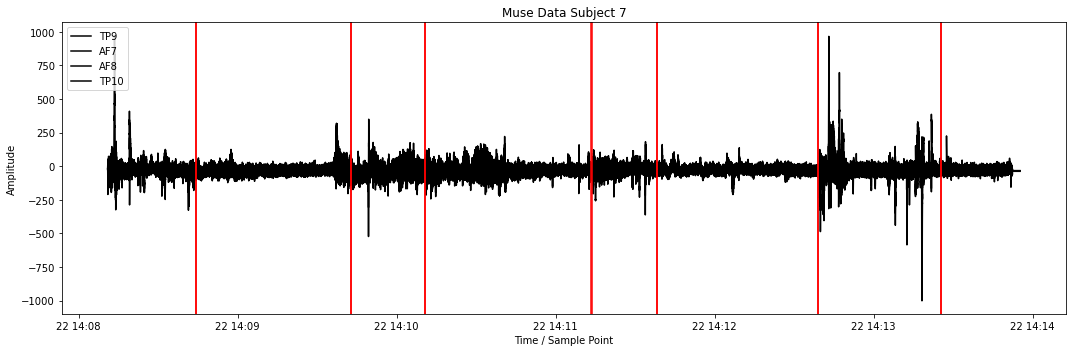

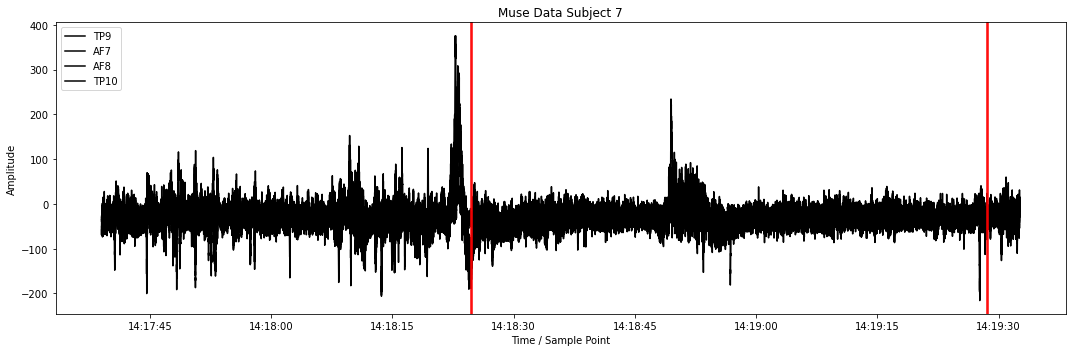

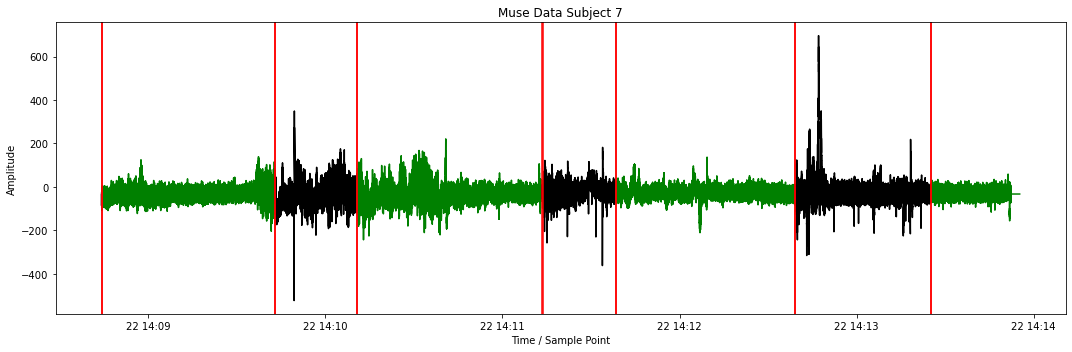

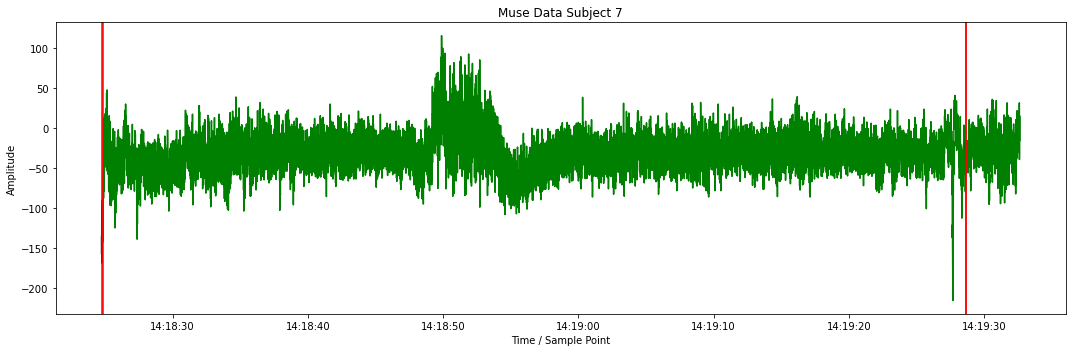

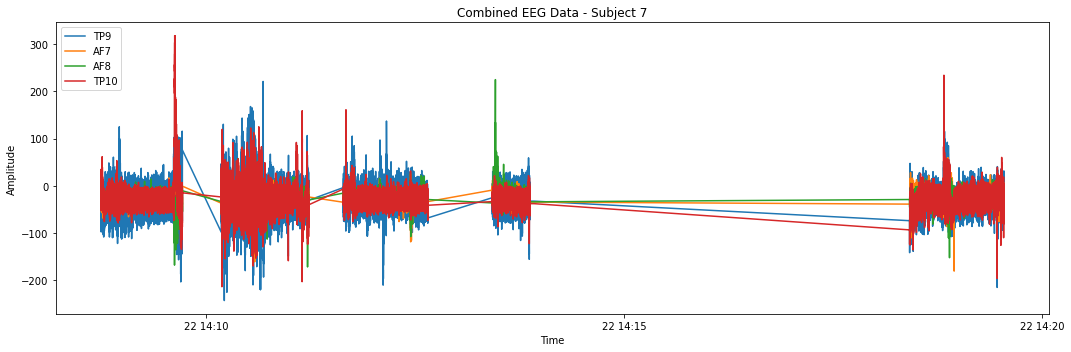

In [50]:
subject_id = 7
df_list = load_subject_data(subject_id=subject_id)

counter = 0
for df in df_list:
    plot_data_plain(df, subject_id=subject_id, counter=counter)
    counter += 1
    
# Has to be done manually...
list_of_indexes = []
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 5, 'black'], [5, 6, 'green'], [6, 9, 'black'], [9, 10, 'green'],
                       [10, 13, 'black'], [13, None, 'green']])
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 3, 'black'], [3, None, 'green']])

df_complete = extract_df_from_events(df_list=df_list, list_of_indexes=list_of_indexes, subject_id=subject_id, plot_df_complete=True)

save_muse_df_to_csv(df=df_complete, subject_id=subject_id, file_ending='reaction_game_complete')

## Manual process Subject 8

Files to exclude: ['complete', 'driving_fatigue.csv', 'driving_complete.csv', 'reaction_game_complete.csv']
Found 'record-[2020.06.22-16.10.27]_reaction_game.csv'
Found 1 dataset(s) containing 'reaction_game'
Saving figure concentration_game_subject_8_plain_0
Saving figure concentration_game_subject_8_with_events_0
Saving figure concentration_game_Combined_EEG_Data_-_Subject_8
Saved reaction_game_complete to: D:\Masterthesis\EEG_Data\muse_data\subject_8\reaction_game_complete.csv


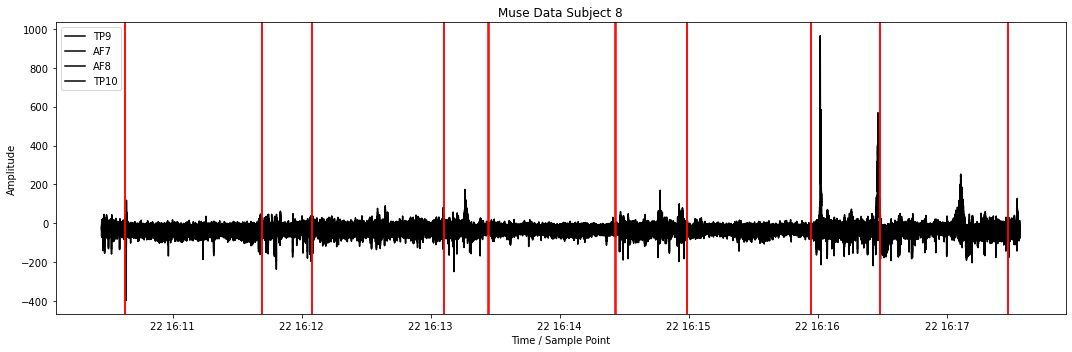

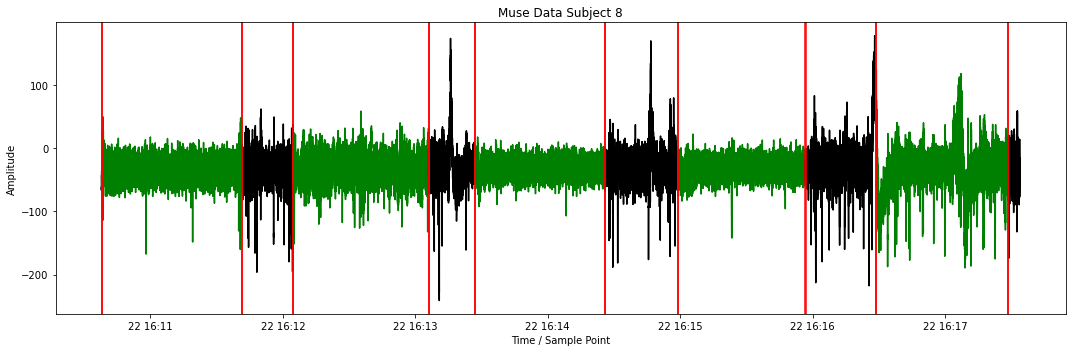

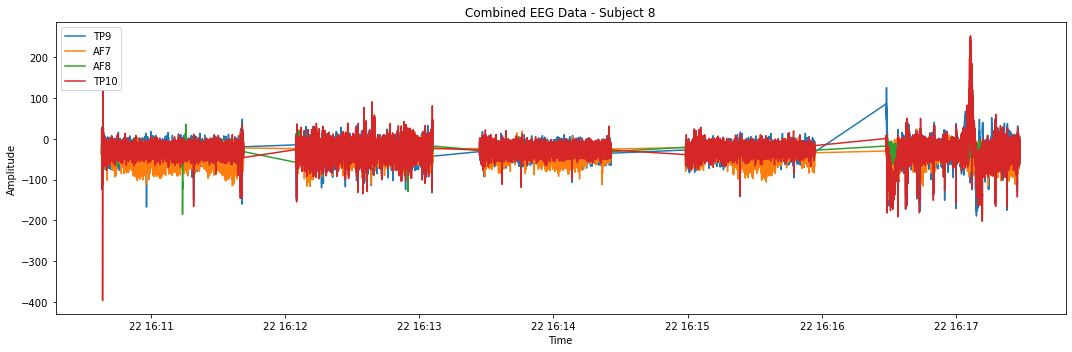

In [51]:
subject_id = 8
df_list = load_subject_data(subject_id=subject_id)

counter = 0
for df in df_list:
    plot_data_plain(df, subject_id=subject_id, counter=counter)
    counter += 1
    
# Has to be done manually...
list_of_indexes = []
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 5, 'black'], [5, 6, 'green'], [6, 9, 'black'], [9, 10, 'green'],
                       [10, 13, 'black'], [13, 14, 'green'], [14, 17, 'black'], [17, 18, 'green'], [18, None, 'black']])

df_complete = extract_df_from_events(df_list=df_list, list_of_indexes=list_of_indexes, subject_id=subject_id, plot_df_complete=True)

save_muse_df_to_csv(df=df_complete, subject_id=subject_id, file_ending='reaction_game_complete')

## Manual process Subject 9

Files to exclude: ['complete', 'driving_fatigue.csv', 'driving_complete.csv', 'reaction_game_complete.csv']
Found 'record-[2020.06.23-15.17.13]_reaction_game.csv'
Found 'record-[2020.06.23-15.24.56]_reaction_game.csv'
Found 2 dataset(s) containing 'reaction_game'
Saving figure concentration_game_subject_9_plain_0
Saving figure concentration_game_subject_9_plain_1
Saving figure concentration_game_subject_9_with_events_0
Saving figure concentration_game_subject_9_with_events_1
Saving figure concentration_game_Combined_EEG_Data_-_Subject_9
Saved reaction_game_complete to: D:\Masterthesis\EEG_Data\muse_data\subject_9\reaction_game_complete.csv


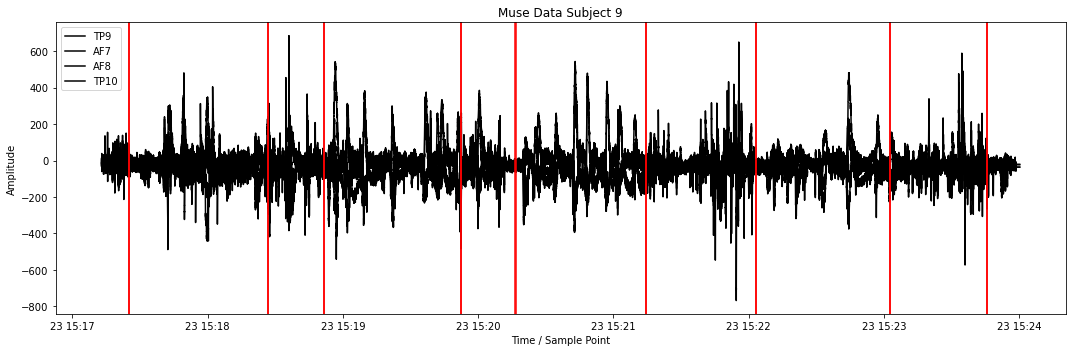

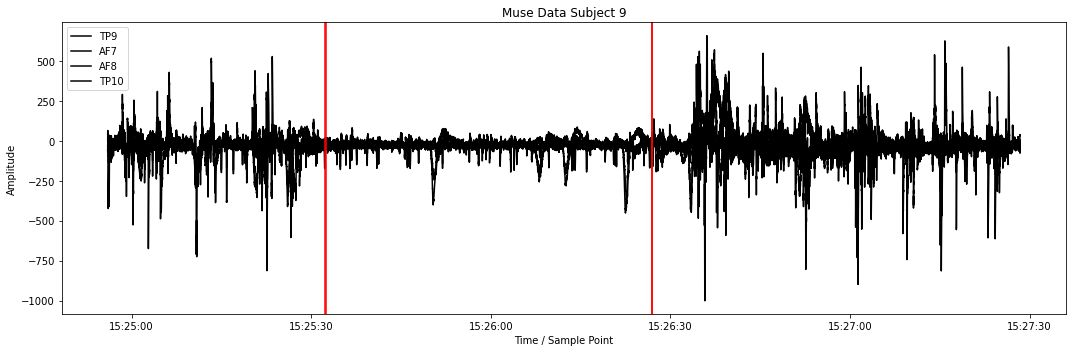

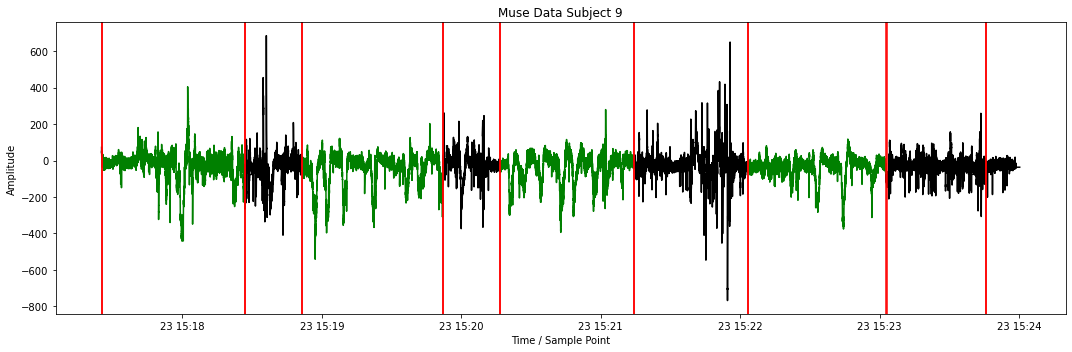

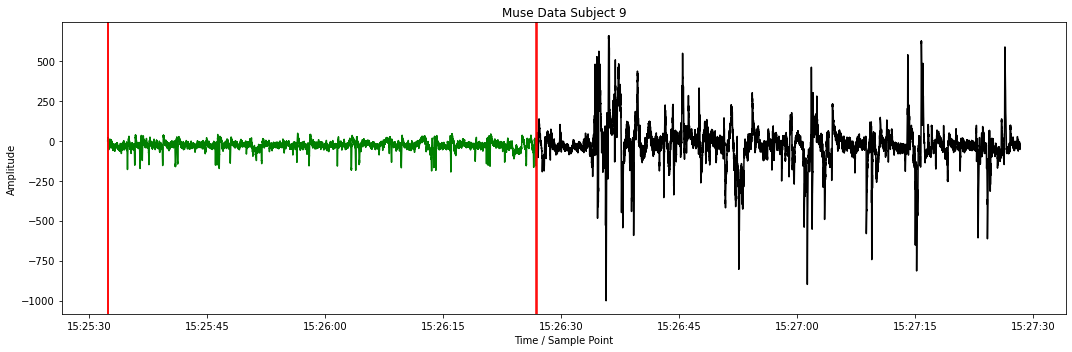

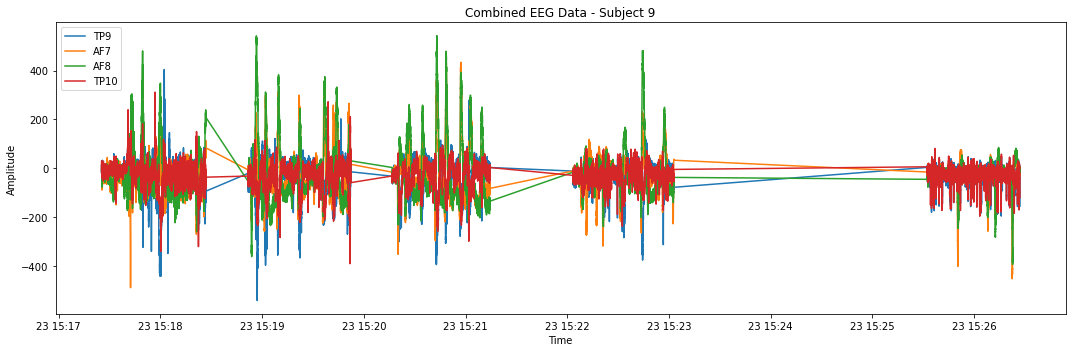

In [52]:
subject_id = 9
df_list = load_subject_data(subject_id=subject_id)

counter = 0
for df in df_list:
    plot_data_plain(df, subject_id=subject_id, counter=counter)
    counter += 1
    
# Has to be done manually...
list_of_indexes = []
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 5, 'black'], [5, 6, 'green'], [6, 9, 'black'], [9, 10, 'green'],
                       [10, 13, 'black'], [13, 14, 'green'], [14, None, 'black']])
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, None, 'black']])

df_complete = extract_df_from_events(df_list=df_list, list_of_indexes=list_of_indexes, subject_id=subject_id, plot_df_complete=True)

save_muse_df_to_csv(df=df_complete, subject_id=subject_id, file_ending='reaction_game_complete')

## Manual process Subject 10

Files to exclude: ['complete', 'driving_fatigue.csv', 'driving_complete.csv', 'reaction_game_complete.csv']
Found 'record-[2020.06.24-15.38.01]_reaction_game.csv'
Found 1 dataset(s) containing 'reaction_game'
Saving figure concentration_game_subject_10_plain_0
Saving figure concentration_game_subject_10_with_events_0
Saving figure concentration_game_Combined_EEG_Data_-_Subject_10
Saved reaction_game_complete to: D:\Masterthesis\EEG_Data\muse_data\subject_10\reaction_game_complete.csv


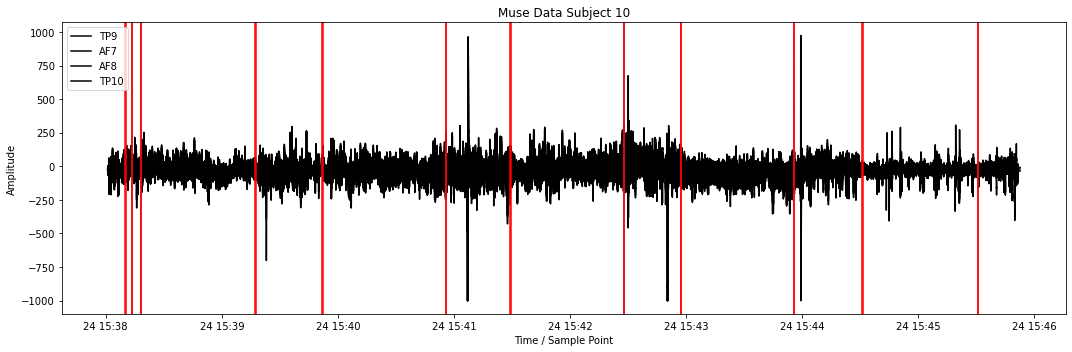

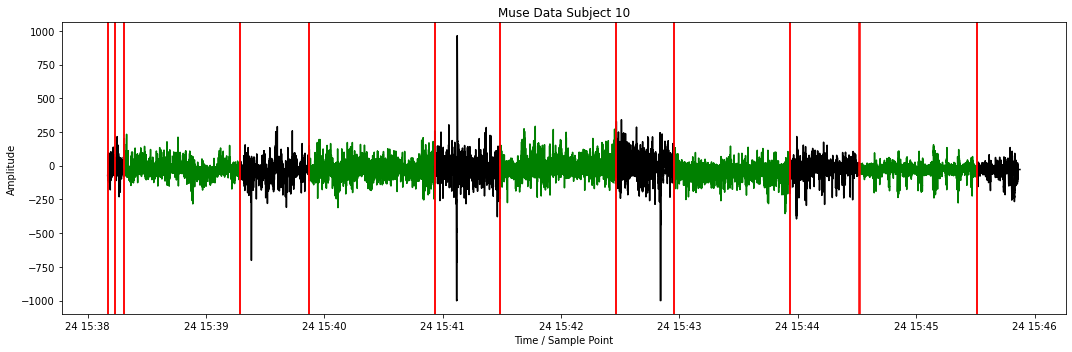

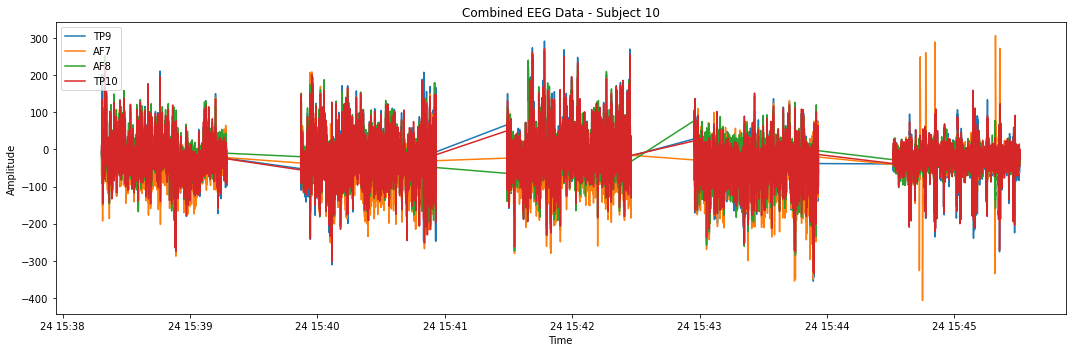

In [53]:
subject_id = 10
df_list = load_subject_data(subject_id=subject_id)

counter = 0
for df in df_list:
    plot_data_plain(df, subject_id=subject_id, counter=counter)
    counter += 1
    
# Has to be done manually...
list_of_indexes = []
list_of_indexes.append([[0, 5, 'black'], [5, 6, 'green'], [6, 9, 'black'], [9, 10, 'green'], [10, 13, 'black'], [13, 14, 'green'],
                        [14, 17, 'black'], [17, 18, 'green'], [18, 21, 'black'], [21, 22, 'green'], [22, None, 'black']])

df_complete = extract_df_from_events(df_list=df_list, list_of_indexes=list_of_indexes, subject_id=subject_id, plot_df_complete=True)

save_muse_df_to_csv(df=df_complete, subject_id=subject_id, file_ending='reaction_game_complete')

## Manual process Subject 11

Files to exclude: ['complete', 'driving_fatigue.csv', 'driving_complete.csv', 'reaction_game_complete.csv']
Found 'record-[2020.06.25-18.57.44]_reaction_game.csv'
Found 'record-[2020.06.25-19.03.54]_reaction_game.csv'
Found 2 dataset(s) containing 'reaction_game'
Saving figure concentration_game_subject_11_plain_0
Saving figure concentration_game_subject_11_plain_1
Saving figure concentration_game_subject_11_with_events_0
Saving figure concentration_game_subject_11_with_events_1
Saving figure concentration_game_Combined_EEG_Data_-_Subject_11
Saved reaction_game_complete to: D:\Masterthesis\EEG_Data\muse_data\subject_11\reaction_game_complete.csv


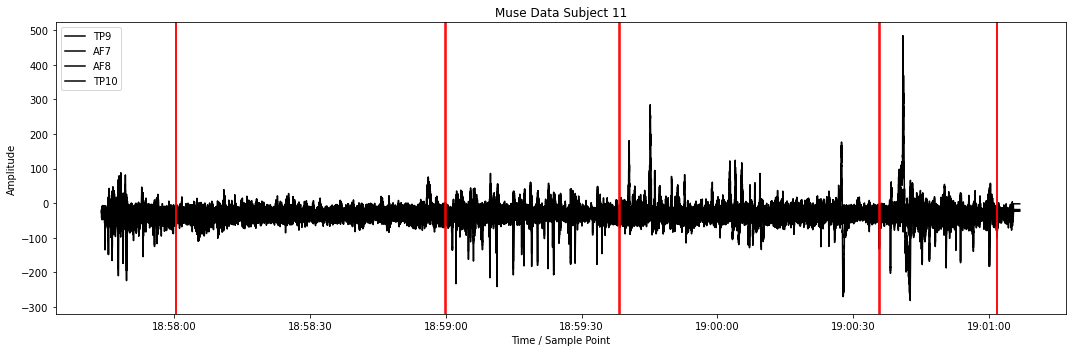

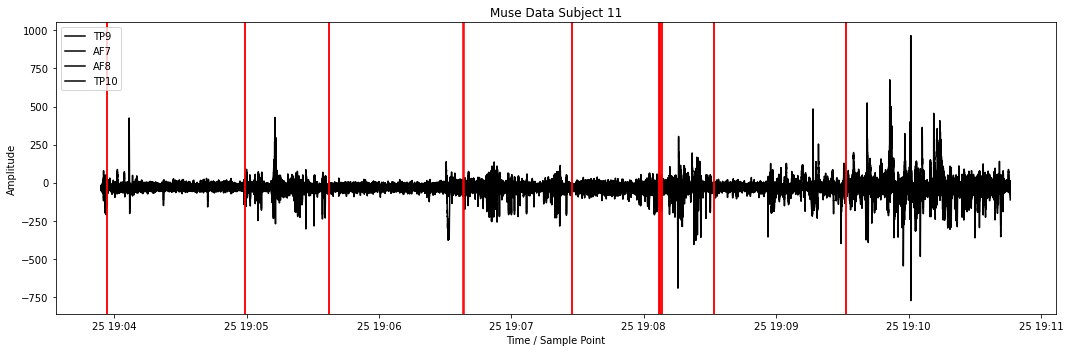

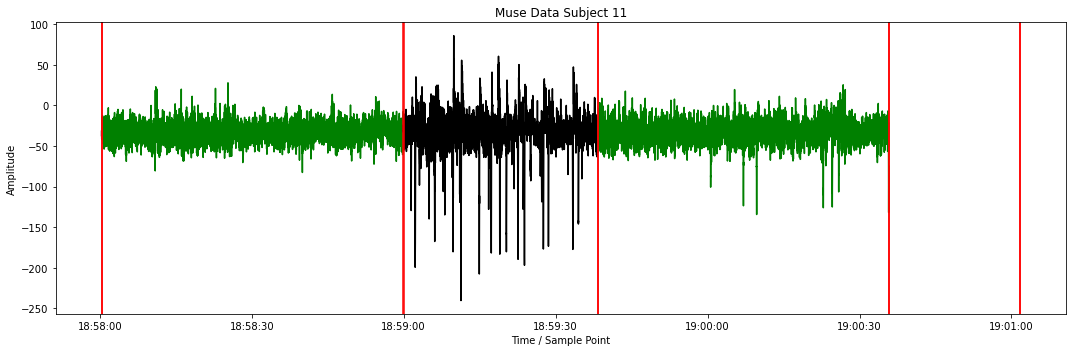

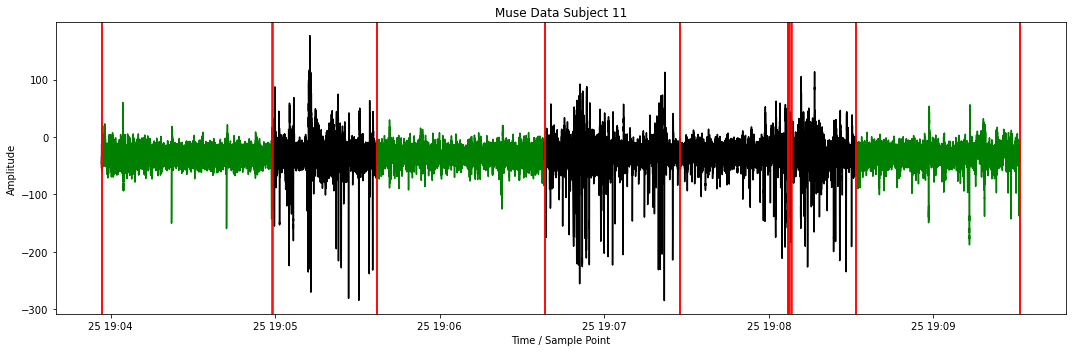

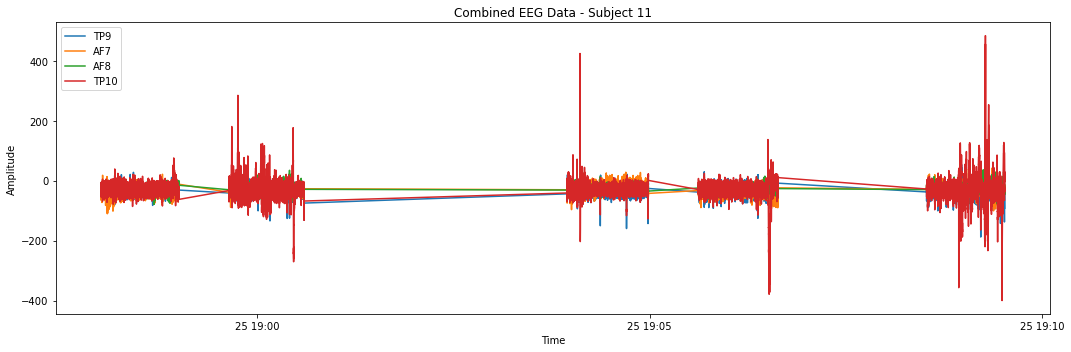

In [54]:
subject_id = 11
df_list = load_subject_data(subject_id=subject_id)

counter = 0
for df in df_list:
    plot_data_plain(df, subject_id=subject_id, counter=counter)
    counter += 1
    
# Has to be done manually...
list_of_indexes = []
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 5, 'black'], [5, 6, 'green']])
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 5, 'black'], [5, 6, 'green'], [6, 17, 'black'], [17, 18, 'green']])

df_complete = extract_df_from_events(df_list=df_list, list_of_indexes=list_of_indexes, subject_id=subject_id, plot_df_complete=True)

save_muse_df_to_csv(df=df_complete, subject_id=subject_id, file_ending='reaction_game_complete')

## Manual process Subject 12

Files to exclude: ['complete', 'driving_fatigue.csv', 'driving_complete.csv', 'reaction_game_complete.csv']
Found 'record-[2020.06.26-12.47.11]_reaction_game.csv'
Found 1 dataset(s) containing 'reaction_game'
Saving figure concentration_game_subject_12_plain_0
Saving figure concentration_game_subject_12_with_events_0
Saving figure concentration_game_Combined_EEG_Data_-_Subject_12
Saved reaction_game_complete to: D:\Masterthesis\EEG_Data\muse_data\subject_12\reaction_game_complete.csv


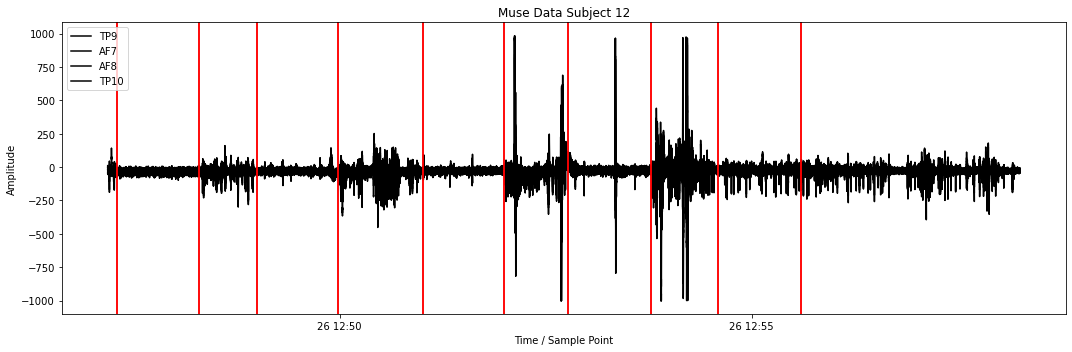

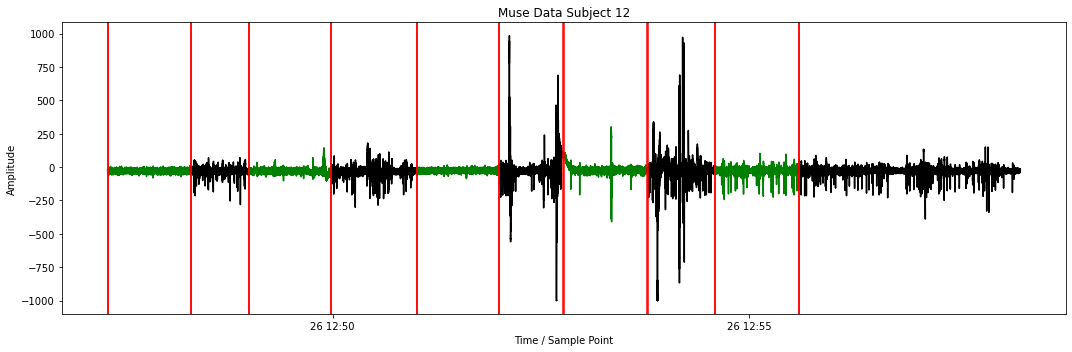

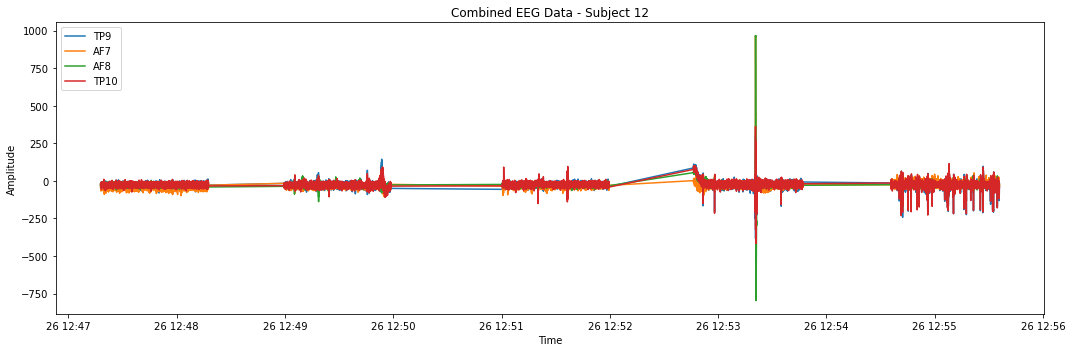

In [55]:
subject_id = 12
df_list = load_subject_data(subject_id=subject_id)

counter = 0
for df in df_list:
    plot_data_plain(df, subject_id=subject_id, counter=counter)
    counter += 1
    
# Has to be done manually...
list_of_indexes = []
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 5, 'black'], [5, 6, 'green'], [6, 9, 'black'], [9, 10, 'green'],
                       [10, 13, 'black'], [13, 14, 'green'], [14, 17, 'black'], [17, 18, 'green'], [18, None, 'black']])

df_complete = extract_df_from_events(df_list=df_list, list_of_indexes=list_of_indexes, subject_id=subject_id, plot_df_complete=True)

save_muse_df_to_csv(df=df_complete, subject_id=subject_id, file_ending='reaction_game_complete')

## Manual process Subject 13

Files to exclude: ['complete', 'driving_fatigue.csv', 'driving_complete.csv', 'reaction_game_complete.csv']
Found 'record-[2020.06.26-15.26.31]_reaction_game.csv'
Found 1 dataset(s) containing 'reaction_game'
Saving figure concentration_game_subject_13_plain_0
Saving figure concentration_game_subject_13_with_events_0
Saving figure concentration_game_Combined_EEG_Data_-_Subject_13
Saved reaction_game_complete to: D:\Masterthesis\EEG_Data\muse_data\subject_13\reaction_game_complete.csv


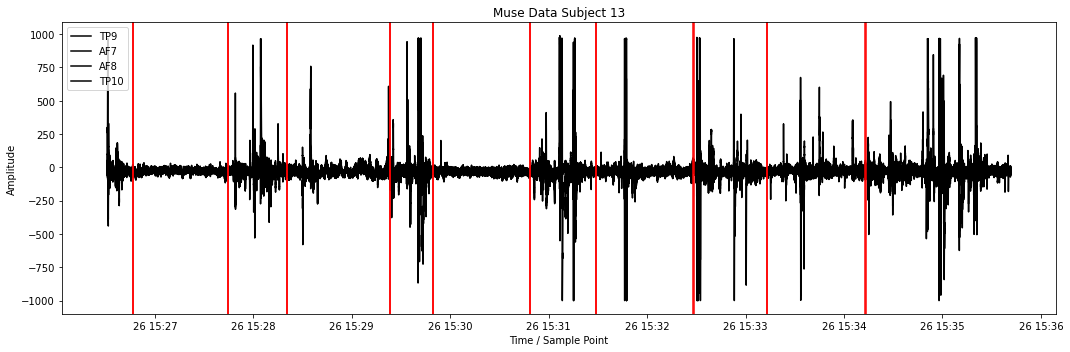

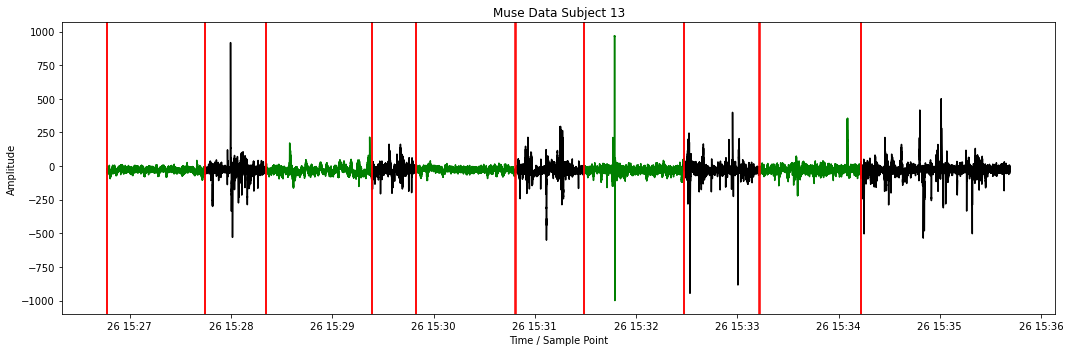

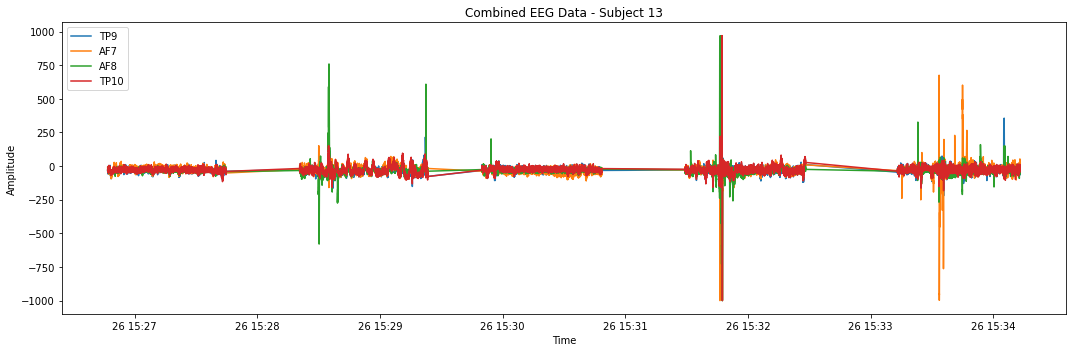

In [56]:
subject_id = 13
df_list = load_subject_data(subject_id=subject_id)

counter = 0
for df in df_list:
    plot_data_plain(df, subject_id=subject_id, counter=counter)
    counter += 1
    
# Has to be done manually...
list_of_indexes = []
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 5, 'black'], [5, 6, 'green'], [6, 9, 'black'], [9, 10, 'green'],
                       [10, 13, 'black'], [13, 14, 'green'], [14, 17, 'black'], [17, 18, 'green'], [18, None, 'black']])

df_complete = extract_df_from_events(df_list=df_list, list_of_indexes=list_of_indexes, subject_id=subject_id, plot_df_complete=True)

save_muse_df_to_csv(df=df_complete, subject_id=subject_id, file_ending='reaction_game_complete')

## Manual process Subject 14

Files to exclude: ['complete', 'driving_fatigue.csv', 'driving_complete.csv', 'reaction_game_complete.csv']
Found 'record-[2020.06.30-15.18.37]_reaction_game.csv'
Found 1 dataset(s) containing 'reaction_game'
Saving figure concentration_game_subject_14_plain_0
Saving figure concentration_game_subject_14_with_events_0
Saving figure concentration_game_Combined_EEG_Data_-_Subject_14
Saved reaction_game_complete to: D:\Masterthesis\EEG_Data\muse_data\subject_14\reaction_game_complete.csv


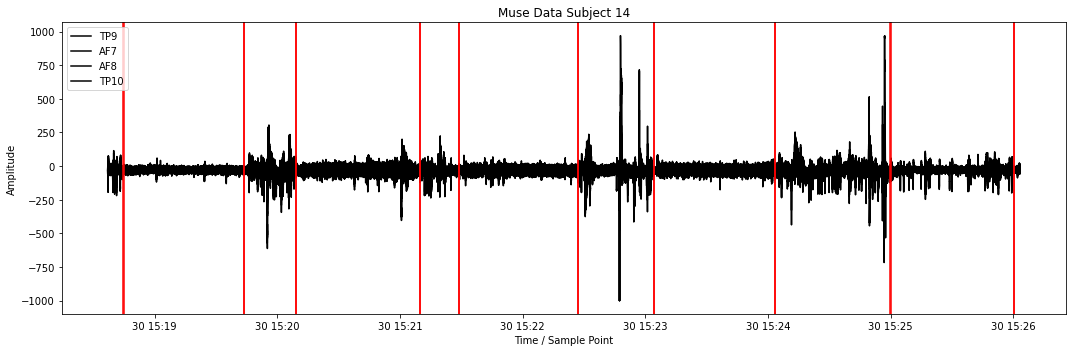

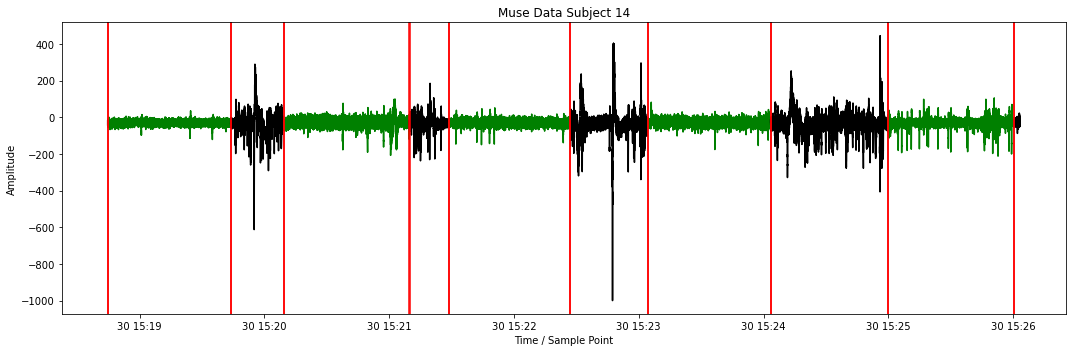

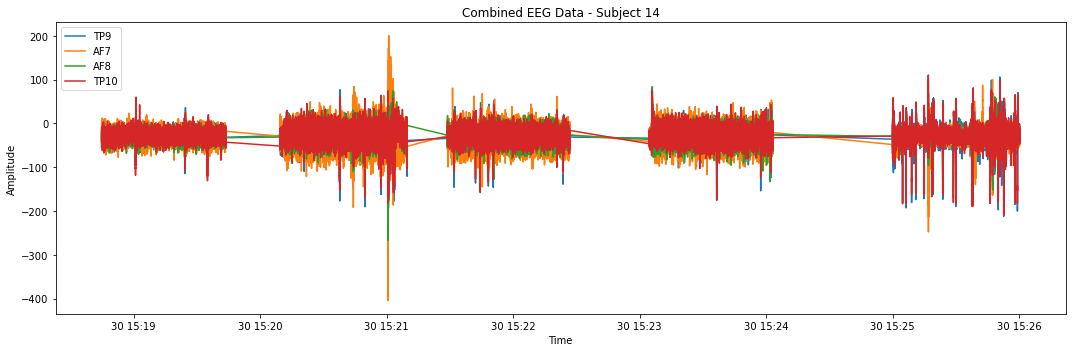

In [57]:
subject_id = 14
df_list = load_subject_data(subject_id=subject_id)

counter = 0
for df in df_list:
    plot_data_plain(df, subject_id=subject_id, counter=counter)
    counter += 1
    
# Has to be done manually...
list_of_indexes = []
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 5, 'black'], [5, 6, 'green'], [6, 9, 'black'], [9, 10, 'green'],
                       [10, 13, 'black'], [13, 14, 'green'], [14, 17, 'black'], [17, 18, 'green'], [18, None, 'black']])

df_complete = extract_df_from_events(df_list=df_list, list_of_indexes=list_of_indexes, subject_id=subject_id, plot_df_complete=True)

save_muse_df_to_csv(df=df_complete, subject_id=subject_id, file_ending='reaction_game_complete')

## Manual process Subject 15

Files to exclude: ['complete', 'driving_fatigue.csv', 'driving_complete.csv', 'reaction_game_complete.csv']
Found 'record-[2020.06.30-18.08.18]_reaction_game.csv'
Found 'record-[2020.06.30-18.15.00]_reaction_game.csv'
Found 2 dataset(s) containing 'reaction_game'
Saving figure concentration_game_subject_15_plain_0
Saving figure concentration_game_subject_15_plain_1
Saving figure concentration_game_subject_15_with_events_0
Saving figure concentration_game_subject_15_with_events_1
Saving figure concentration_game_Combined_EEG_Data_-_Subject_15
Saved reaction_game_complete to: D:\Masterthesis\EEG_Data\muse_data\subject_15\reaction_game_complete.csv


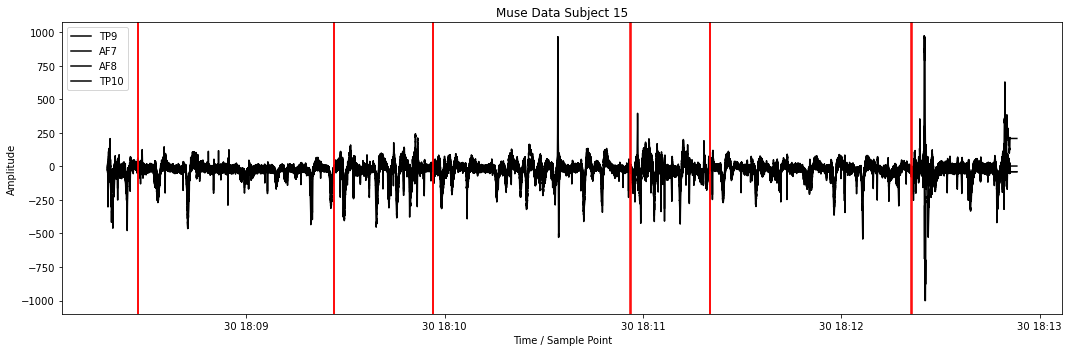

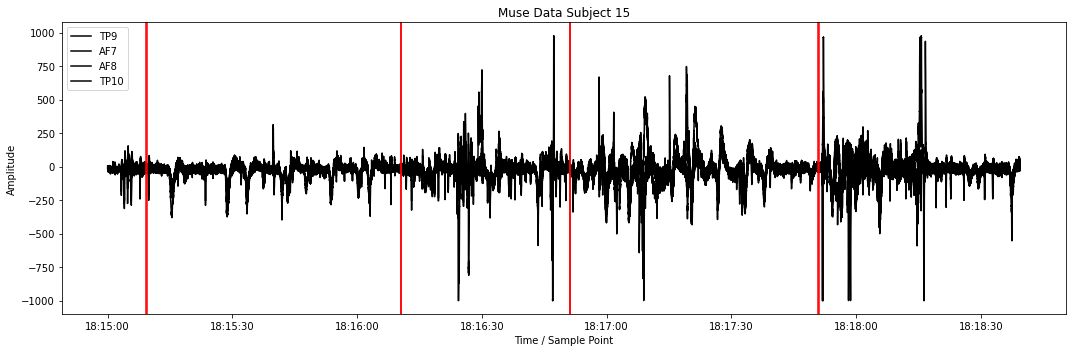

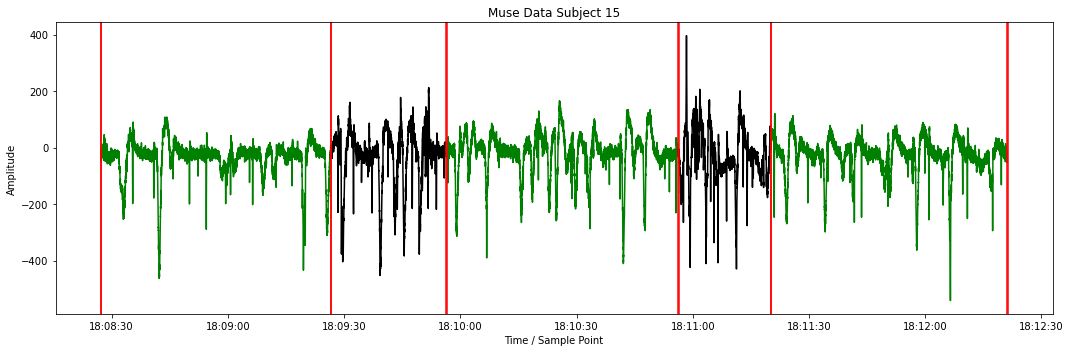

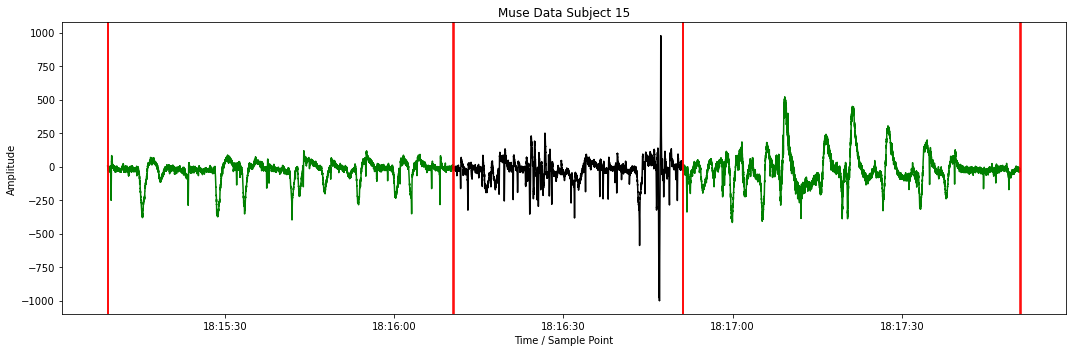

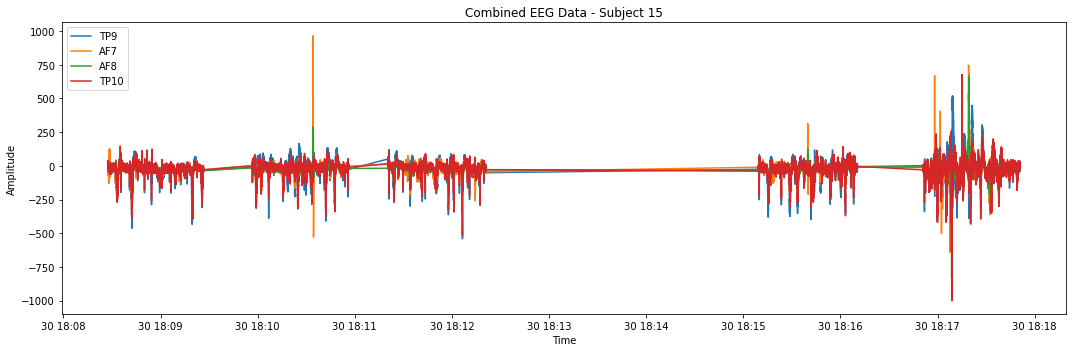

In [58]:
subject_id = 15
df_list = load_subject_data(subject_id=subject_id)

counter = 0
for df in df_list:
    plot_data_plain(df, subject_id=subject_id, counter=counter)
    counter += 1
    
# Has to be done manually...
list_of_indexes = []
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 5, 'black'], [5, 6, 'green'], [6, 9, 'black'], [9, 10, 'green']])
list_of_indexes.append([[0, 1, 'black'], [1, 2, 'green'], [2, 5, 'black'], [5, 6, 'green']])

df_complete = extract_df_from_events(df_list=df_list, list_of_indexes=list_of_indexes, subject_id=subject_id, plot_df_complete=True)

save_muse_df_to_csv(df=df_complete, subject_id=subject_id, file_ending='reaction_game_complete')